# HandWritten Text Extraction

### Importing Dependencies

In [1]:
import cv2,os,csv , time
import numpy as np
import keras_ocr
import matplotlib.pyplot as plt
from spellchecker import spellchecker
import pandas as pd
from PIL import Image, ImageEnhance

2021-11-08 15:43:12.404398: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-08 15:43:12.404526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Initiating Keras in-built pipline to  OCR-model

In [2]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/rohit/.keras-ocr/craft_mlt_25k.h5


2021-11-08 15:43:19.081368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-08 15:43:19.081421: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-08 15:43:19.081458: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rohit): /proc/driver/nvidia/version does not exist
2021-11-08 15:43:19.081904: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-08 15:43:19.411972: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 18874368 exceeds 10% 

Looking for /home/rohit/.keras-ocr/crnn_kurapan.h5


### Spliting Main Image into Saperate color image with text only.

In [3]:
def rgb(img):
    image = cv2.imread(img, -1)
    # image = cv2.rotate(image,cv2.cv2.ROTATE_90_CLOCKWISE)
    bhsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    bmask = cv2.inRange(bhsv, np.array([110, 50, 50]), np.array([130, 255, 255]))
    # print(j)
    ### finding red color only
    rhsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
#     rmask = cv2.inRange(rhsv, np.array([165, 155, 84]), np.array([179, 255, 255]))
    rmask = cv2.inRange(rhsv,np.array([0,20 ,60]),np.array([60,180,255]))
    gmask = cv2.inRange(rhsv, np.array([40, 20, 50]), np.array([100, 100, 180]))    ## for pdf images
#     gmask = cv2.inRange(rhsv, np.array([40, 60, 25]), np.array([100, 255, 255]))  ## for normal image
    # gmask = cv2.inRange(rhsv,np.array([65,60,60]), np.array([80, 255,255]))
    inv_bmask = cv2.bitwise_and(image, image, mask=bmask)
    kernel = np.ones((1, 1), np.uint8)
    _, ir = cv2.threshold(rmask, 50, 200, cv2.THRESH_BINARY_INV)
    ir = cv2.erode(ir,kernel,iterations=1)
    cv2.imwrite("ir.jpg", ir)
    _, ib = cv2.threshold(bmask, 50, 200, cv2.THRESH_BINARY_INV)
    # ib = cv2.erode(ib, kernel, iterations=1)
    cv2.imwrite("ib.jpg", ib)
    _, ig = cv2.threshold(gmask, 20, 250, cv2.THRESH_BINARY_INV)
    # ig = cv2.erode(ig, kernel, iterations=1)
    cv2.imwrite("ig.jpg", ig)

    ### For black
    # black_mask = cv2.inRange(bhsv, np.array([0, 0, 0]), np.array([150, 30, 150]))
    black_mask = cv2.inRange(bhsv, np.array([0, 0, 0]), np.array([100, 185, 60]))
    res_bl = cv2.bitwise_and(image, image, mask=black_mask)
    _, iblack = cv2.threshold(res_bl, 5, 250, cv2.THRESH_BINARY_INV)  ## inverted green
    cv2.imwrite("bl_text.jpg", iblack)

### Extracting the text fromeach saperate color images as a Region Of Interest(ROI)

In [4]:
def extractROI(image):
    # Load image, grayscale, Gaussian blur, adaptive threshold
    extimg = cv2.imread(image)
    gray = cv2.cvtColor(extimg, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9,9), 0)
    thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    ROI_number = 0

    textColor = " "

    if image.startswith("ib"):
        textColor = "Blue"
    if image.startswith("ir"):
        textColor = "Red"
    if image.startswith("ig"):
        textColor = "Green"
    if image.startswith("bl"):
        textColor = "Black"

    df = pd.DataFrame(
        {"ImageName": [],
         "y-20": [],
         "y+h": [],
         "x-60": [],
         "x+w+60": [],
         "TextColor": []
         },dtype=int
    )
    with open("r.csv", 'w') as cfile:
        wr = csv.writer(cfile)
        wr.writerow(["Left","Right","ImageName","TextColor"])
        for c in cnts:
            area = cv2.contourArea(c)
            if area > 10000:
                x,y,w,h = cv2.boundingRect(c)
                left = y-50, y+h
                right = x-60, x+w+70

                # pair = [left,right]
                ## creating a dataframe
                df2 = pd.DataFrame(
                    {   "ImageName":["ROI_{}.jpg".format(ROI_number)],
                        "y-20":[y-20],
                        "y+h":[y+h],
                        "x-60":[x-60],
                        "x+w+60":[x+w+60],
                        "TextColor":[textColor]
                    }
                )

                df = df.append(df2)

                if textColor == "Blue":
                    ROI = extimg[left[0]:left[1], right[0]+40:right[1]-30]
                    cv2.imwrite('ROI/ROI_{}.png'.format(ROI_number), ROI)
                    wr.writerow([left,right,"ROI_{}.jpg".format(ROI_number),textColor])
                    ROI_number += 1
                else:
                    ROI = extimg[left[0]:left[1], right[0]+30:right[1]-30]
                    cv2.imwrite('ROI/ROI_{}.png'.format(ROI_number), ROI)
                    wr.writerow([left,right,"ROI_{}.jpg".format(ROI_number),textColor])
                    ROI_number += 1
    print(df)
    return df


### Scaling all ROI 

In [5]:
def scale_img():
    files = []
    for i in os.listdir("ROI"):
        if i.endswith('png'):
            files.append(i)
    files.sort()
    # print(files)
    c = 0
    for j in files:
        im = cv2.imread("ROI/" + str(j), -1)
        resize_image = cv2.resize(im, (350, 130))
        cv2.imwrite("resize/ROI_{}.png".format(c), resize_image)
        # print(j,os.path.exists("ROI/" + str(j)))
        c+=1

### Some Pre-processing with ROI Images

In [6]:
def dilate_erode():
    ## DILATION & EROSION
    files = []
    for j in os.listdir("resize"):
        if j.endswith("png"):
            files.append(j)
    files.sort()
    # print("fnames : ", files)

    for i in files:
        img_ = cv2.imread('resize/' + str(i), -1)
        #         print(img_)

        # Taking a matrix of size 5 as the kernel
        kernel = np.ones((3, 3), np.uint8)
        kernel_ = np.ones((5, 5), np.uint8)
        #         plt.figure(figsize=(9,9))
        #         plt.imshow(img_)

        img_erosion = cv2.erode(img_, kernel, iterations=2)
        erosion = cv2.erode(img_, kernel, iterations=1)
        img_dilation = cv2.dilate(img_, kernel_, iterations=1)
        er2 = cv2.erode(img_dilation, kernel, iterations=1)

        kernelsh = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
        sharp1 = cv2.filter2D(img_erosion, -1, kernelsh)

        di2 = cv2.dilate(img_erosion, kernel_, iterations=1)
        sharp2 = cv2.filter2D(di2,-1,kernelsh)

        gausBlur = cv2.GaussianBlur(img_, (5, 5), 0)
        medBlur = cv2.medianBlur(img_, 3)
        bilFilter = cv2.bilateralFilter(img_, 9, 75, 75)

        bi_ = cv2.bilateralFilter(img_erosion,9, 75, 75)
        bi_di_ = cv2.bilateralFilter(di2,9, 75, 75)

        sharp3 = cv2.filter2D(gausBlur,-1,kernelsh)
        sharp4 = cv2.filter2D(bi_,-1,kernelsh)
        sharp5 = cv2.filter2D(medBlur,-1,kernelsh)
        sharp6 = cv2.filter2D(bi_di_,-1,kernelsh)

        # cv2.imwrite('Input', img)
        cv2.imwrite('resize/erode/Erode_{}.jpg'.format(i[:len(i) - 4]), img_erosion)
        cv2.imwrite('resize/erode1/Erode_{}.jpg'.format(i[:len(i) - 4]), erosion)
        cv2.imwrite('resize/dilate/Dilate_{}.jpg'.format(i[:len(i)-4]), img_dilation)
        cv2.imwrite('resize/gauss/gauss_{}.jpg'.format(i[:len(i)-4]), gausBlur)
        cv2.imwrite('resize/median/median_{}.jpg'.format(i[:len(i)-4]), medBlur)
        cv2.imwrite('resize/bifilter/bi_{}.jpg'.format(i[:len(i)-4]), bilFilter)
        cv2.imwrite('resize/di_/di_{}.jpg'.format(i[:len(i) - 4]), di2)
        cv2.imwrite('resize/er_/er_{}.jpg'.format(i[:len(i)-4]), er2)
        cv2.imwrite('resize/er_bi_/bi_{}.jpg'.format(i[:len(i)-4]), bi_)
        cv2.imwrite('resize/bid/bid_{}.jpg'.format(i[:len(i)-4]), bi_di_)
        cv2.imwrite('resize/s1/s1_{}.jpg'.format(i[:len(i)-4]), sharp1)
        cv2.imwrite('resize/s2/s2_{}.jpg'.format(i[:len(i)-4]), sharp2)
        cv2.imwrite('resize/gauss_sh/gsh_{}.jpg'.format(i[:len(i)-4]), sharp3)
        cv2.imwrite('resize/er_bi_sh/bsh_{}.jpg'.format(i[:len(i)-4]), sharp4)
        cv2.imwrite('resize/median_sh/msh_{}.jpg'.format(i[:len(i)-4]), sharp5)
        cv2.imwrite('resize/bid_sh/bidsh_{}.jpg'.format(i[:len(i)-4]), sharp6)


### Recognising ROI's text by Keras-OCR

In [7]:

def text_recognition(imagepath):
    # keras-ocr will automatically download pretrained
    # weights for the detector and recognizer.

    word ,filename = "",""
    pred  = ()
    data_ = []

    # for i in os.listdir(imagepath):
    #     print(i,type(i))

    for i in os.listdir(imagepath):
        if i.endswith("png") or i.endswith('jpg'):
            # Get a set of three example images
            images = [keras_ocr.tools.read(url) for url in [str(imagepath) +"/"+ str(i)]]
            # print(str(imagepath) +"/"+ str(i))
            filename = i
            # Each list of predictions in prediction_groups is a list of
            # (word, box) tuples.

            prediction_groups = pipeline.recognize(images)
            # Plot the predictions
            fig, axs = plt.subplots(nrows=len(images) + 1, figsize=(20, 20))
            for ax, image, predictions in zip(axs, images, prediction_groups):
                #     pred = spell.correction(predictions[:1])
                keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)
                pred = predictions

            for w in pred:
                word = str(w[0])
            # word = spellchecker.SpellChecker().correction(word)
            data_.append((filename,word))
    return data_


### Initialising recogninsed text on its Coordinate

In [8]:
def text_init(image,impth,col):
    df = extractROI(image)
    scale_img()
    dilate_erode()

    pre = " "
    if impth.endswith("di_"):
        pre = "di_"
    elif impth.endswith("de"):
        pre = "Erode_"
    elif impth.endswith("de1"):
        pre = "Erode_"
    elif impth.endswith("median"):
        pre = "median_"
    elif impth.endswith("gauss"):
        pre = "gauss_"
    elif impth.endswith("bi_") :
        pre = "bi_"
    elif impth.endswith("bifilter") :
        pre = "bi_"
    elif impth.endswith("s1") :
        pre = "s1_"
    elif impth.endswith("s2") :
        pre = "s2_"
    elif impth.endswith("gauss_sh") :
        pre = "gsh_"
    elif impth.endswith("median_sh") :
        pre = "msh_"
    elif impth.endswith("er_bi_sh") :
        pre = "bsh_"
    elif impth.endswith("bid_sh") :
        pre = "bidsh_"
    elif impth.endswith("bid") :
        pre = "bid_"

    txt_col = ()
    if col == 'blue':
        txt_col = (255, 0, 0)
    elif col == 'green':
        txt_col = (36,255,12)
    elif col == 'red':
        txt_col = (0, 0, 255)
    elif col == 'black':
        txt_col = (0, 0, 0)

    extimg = cv2.imread(image)
    gray = cv2.cvtColor(extimg, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 30)

    # Dilate to combine adjacent text contours
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
    dilate = cv2.dilate(thresh, kernel, iterations=4)

    # Find contours, highlight text areas, and extract ROIs
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    bbox_ = None
    x, y = None, None
    text_data = text_recognition(impth)
    # print(text_data)
    ROI_number ,count = 0,0
    # read = []
    # for c in cnts:
    #     area = cv2.contourArea(c)
    #     if area > 10000:
    for d in text_data:
        # print("entered in text data loop")
        for e, p, q, r, s in zip(df['ImageName'], df['x-60'], df['y-20'], df['x+w+60'], df['y+h']):
            # print("entered to iterate csv")
            print(pre+e)
            if d[0] == pre+e:

                print( "Condition Satisfied", pre+e , " = " , d[0] )

                """ y-20:y+h","x-60:x+w+60 """

                checked_text = spellchecker.SpellChecker().correction(d[1])

                # bbox_ = cv2.rectangle(extimg, (df['x-60'][count]+30, df['y-20'][count]), (df['x+w+60'][count], df['y+h'][count]), (36,255,12), 3)
                text = cv2.putText(extimg,checked_text,(p+50 ,q+110),cv2.FONT_HERSHEY_SIMPLEX, 3,txt_col,7)
                cv2.imwrite('put_text_{}.jpg'.format(col),text)
                # cv2.imwrite('final.jpg',text)
                count += 1
                print("Reconised Text of {} is {}".format(d[0],d[1]))
            else:
                print(pre+e," =/= " ,d[0])


### Calling functions

Sorry.. Invalid File
   ImageName  y-20  y+h  x-60  x+w+60 TextColor
0  ROI_0.jpg   676  803  1689    2223      Blue


/usr/local/lib/python3.8/dist-packages/keras_ocr/tools.py:156: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s=text,


bi_ROI_0.jpg
bi_ROI_0.jpg  =/=  bi_ROI_4.jpg
bi_ROI_0.jpg
bi_ROI_0.jpg  =/=  bi_ROI_2.jpg
bi_ROI_0.jpg
Condition Satisfied bi_ROI_0.jpg  =  bi_ROI_0.jpg
Reconised Text of bi_ROI_0.jpg is ymm
bi_ROI_0.jpg
bi_ROI_0.jpg  =/=  bi_ROI_1.jpg
bi_ROI_0.jpg
bi_ROI_0.jpg  =/=  bi_ROI_5.jpg
bi_ROI_0.jpg
bi_ROI_0.jpg  =/=  bi_ROI_3.jpg
Sorry.. Invalid File
Sorry.. Invalid File
8.008251428604126


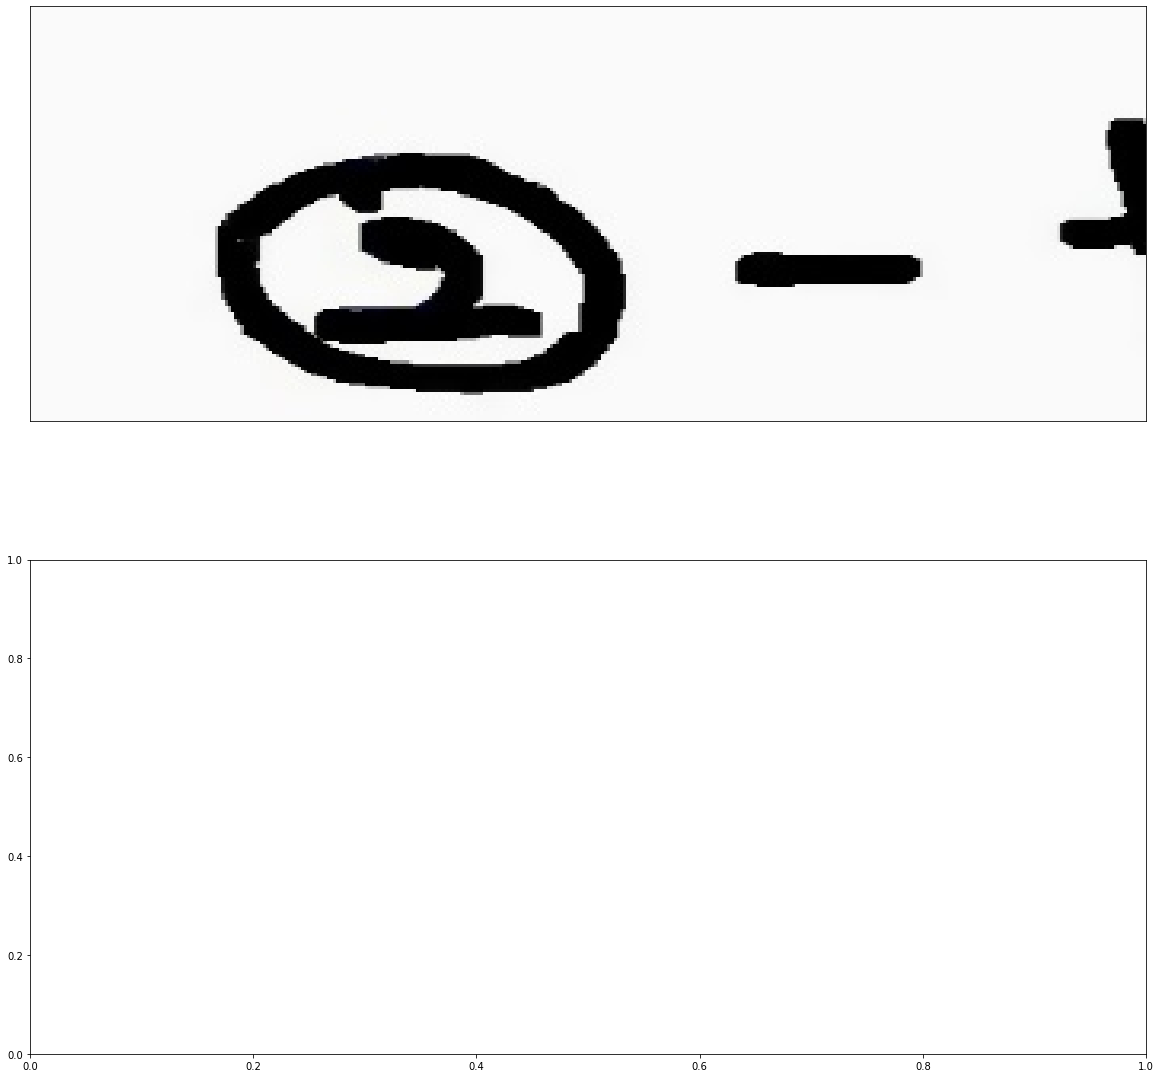

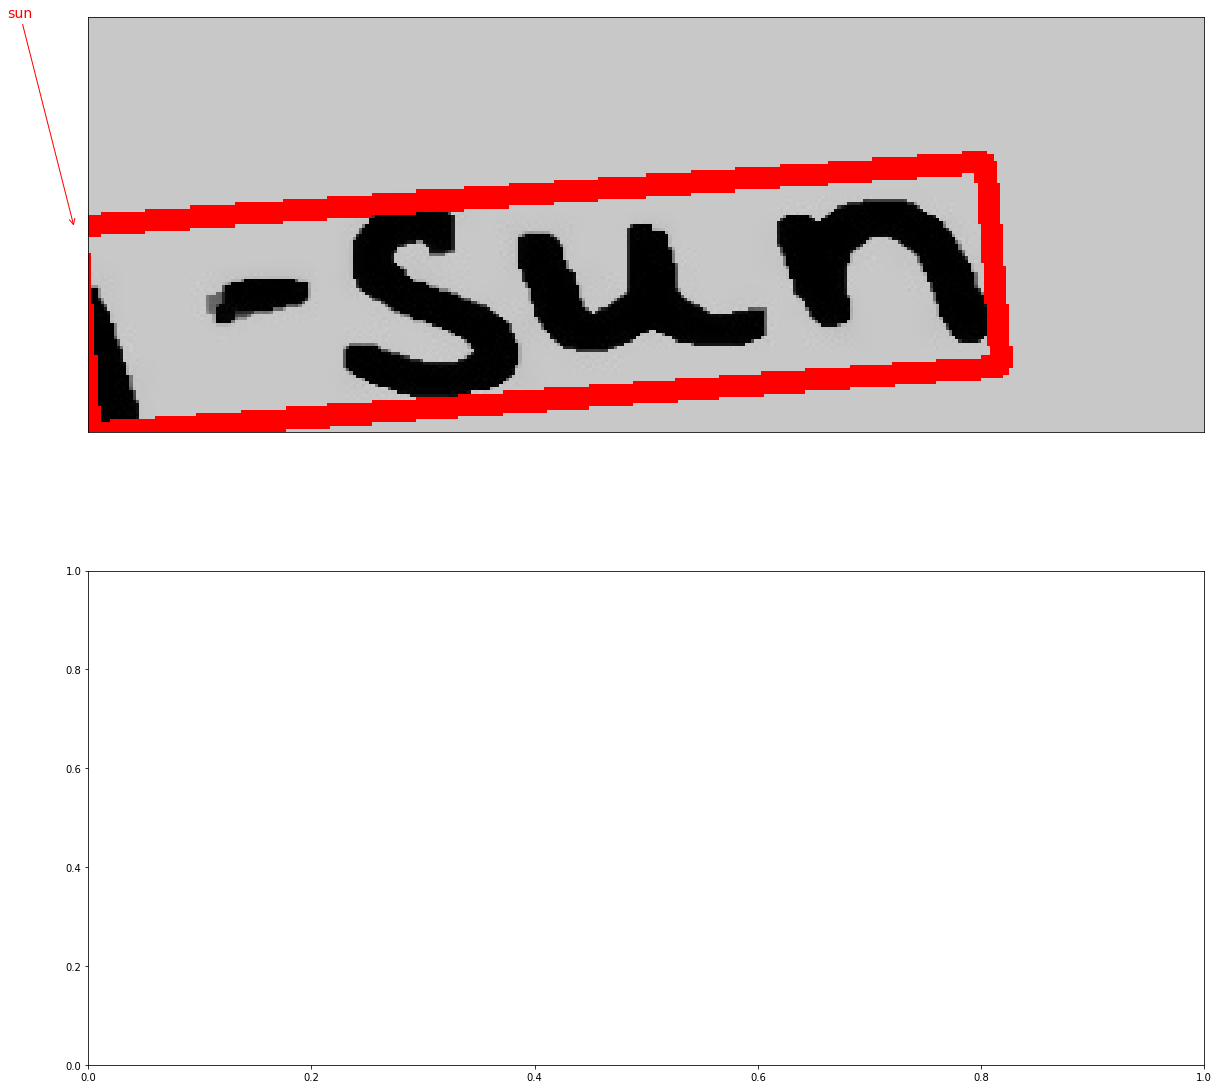

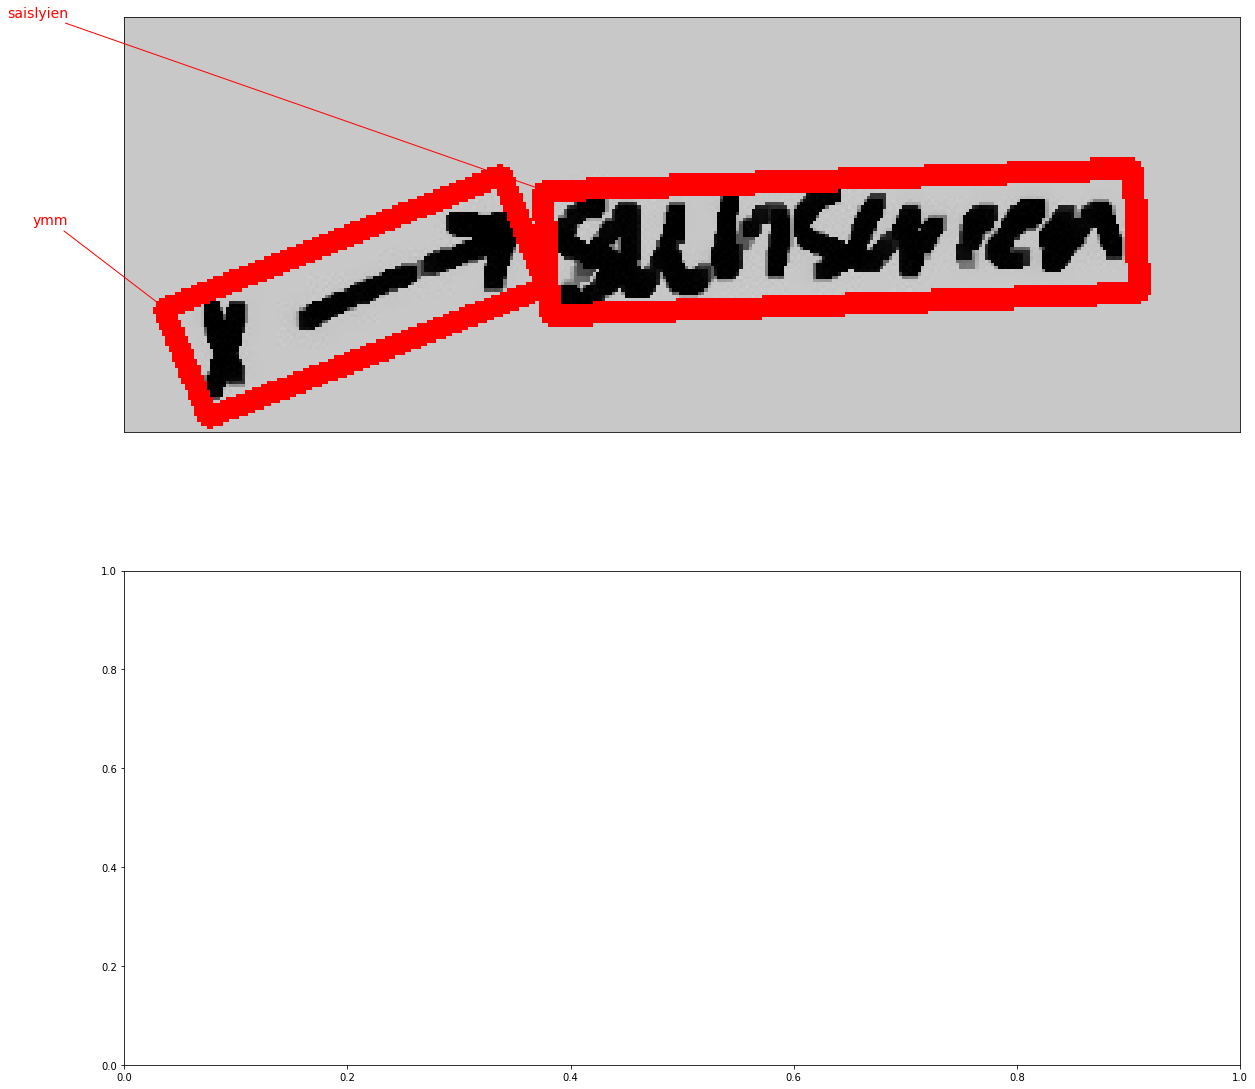

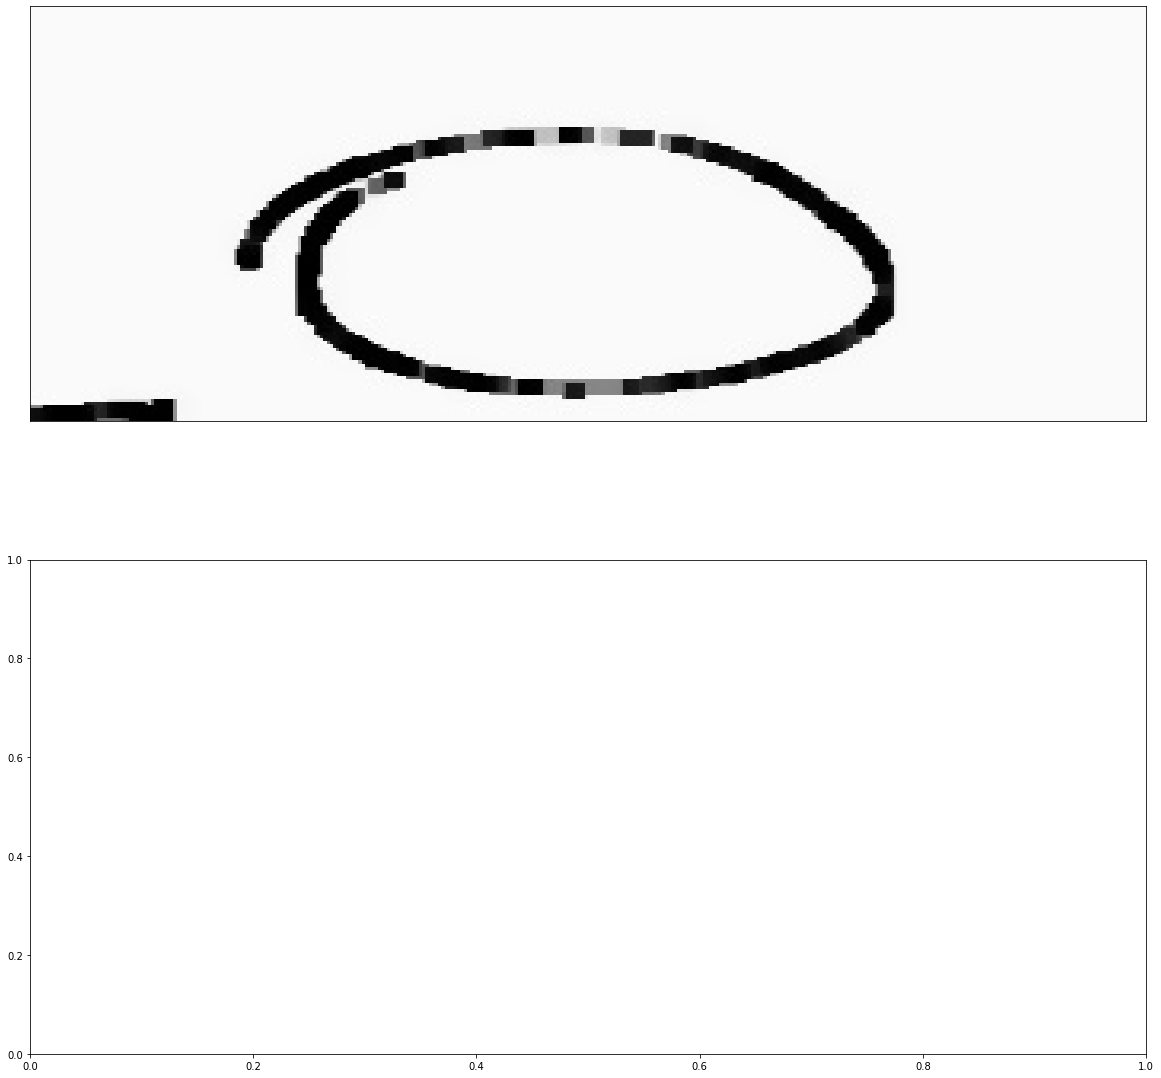

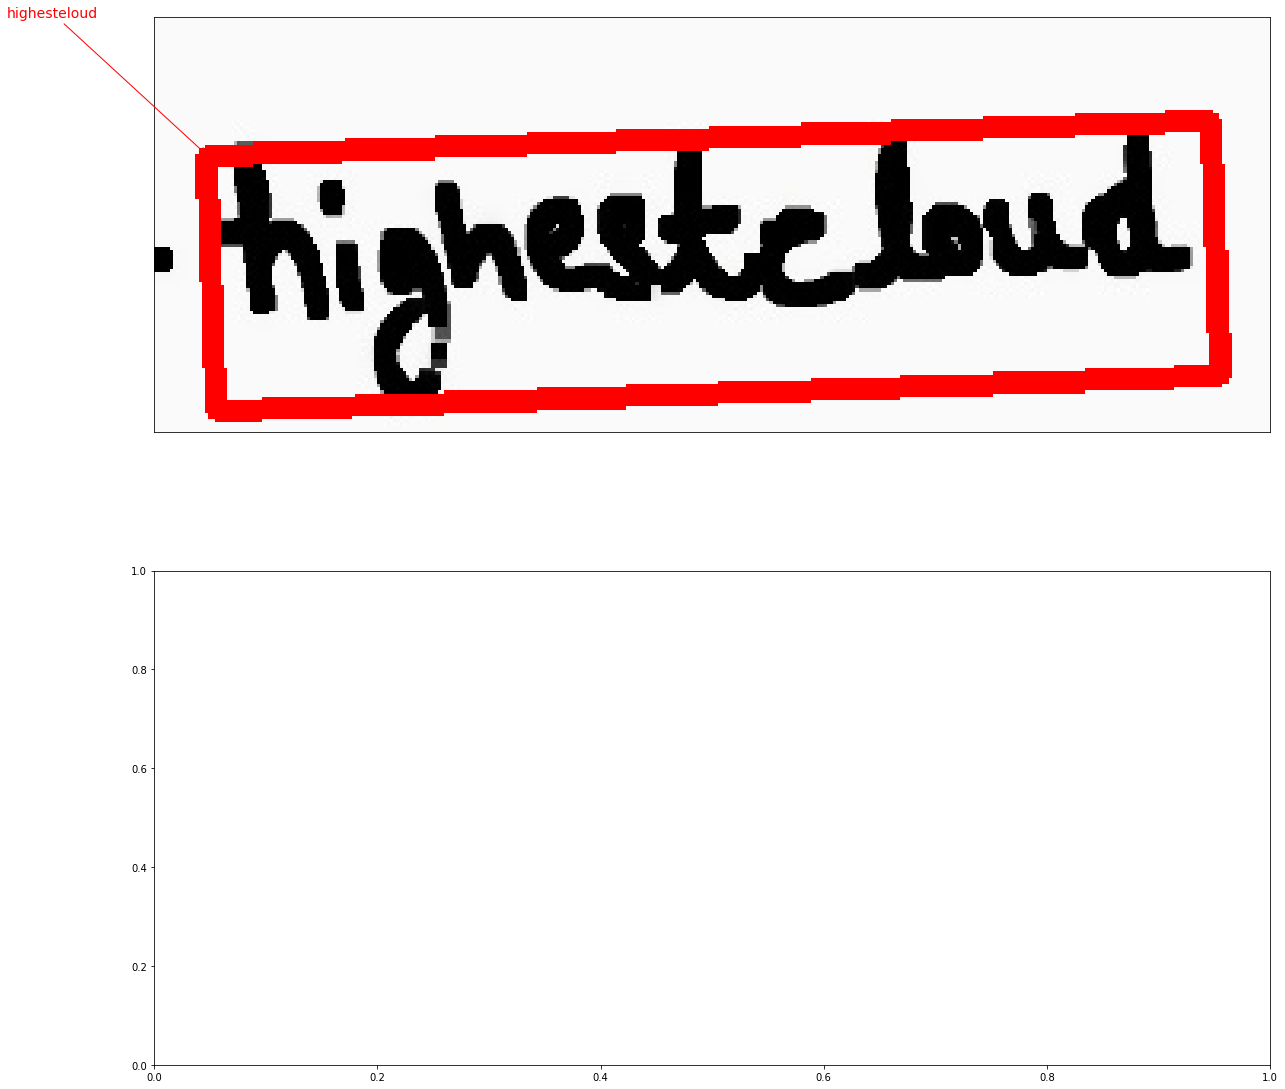

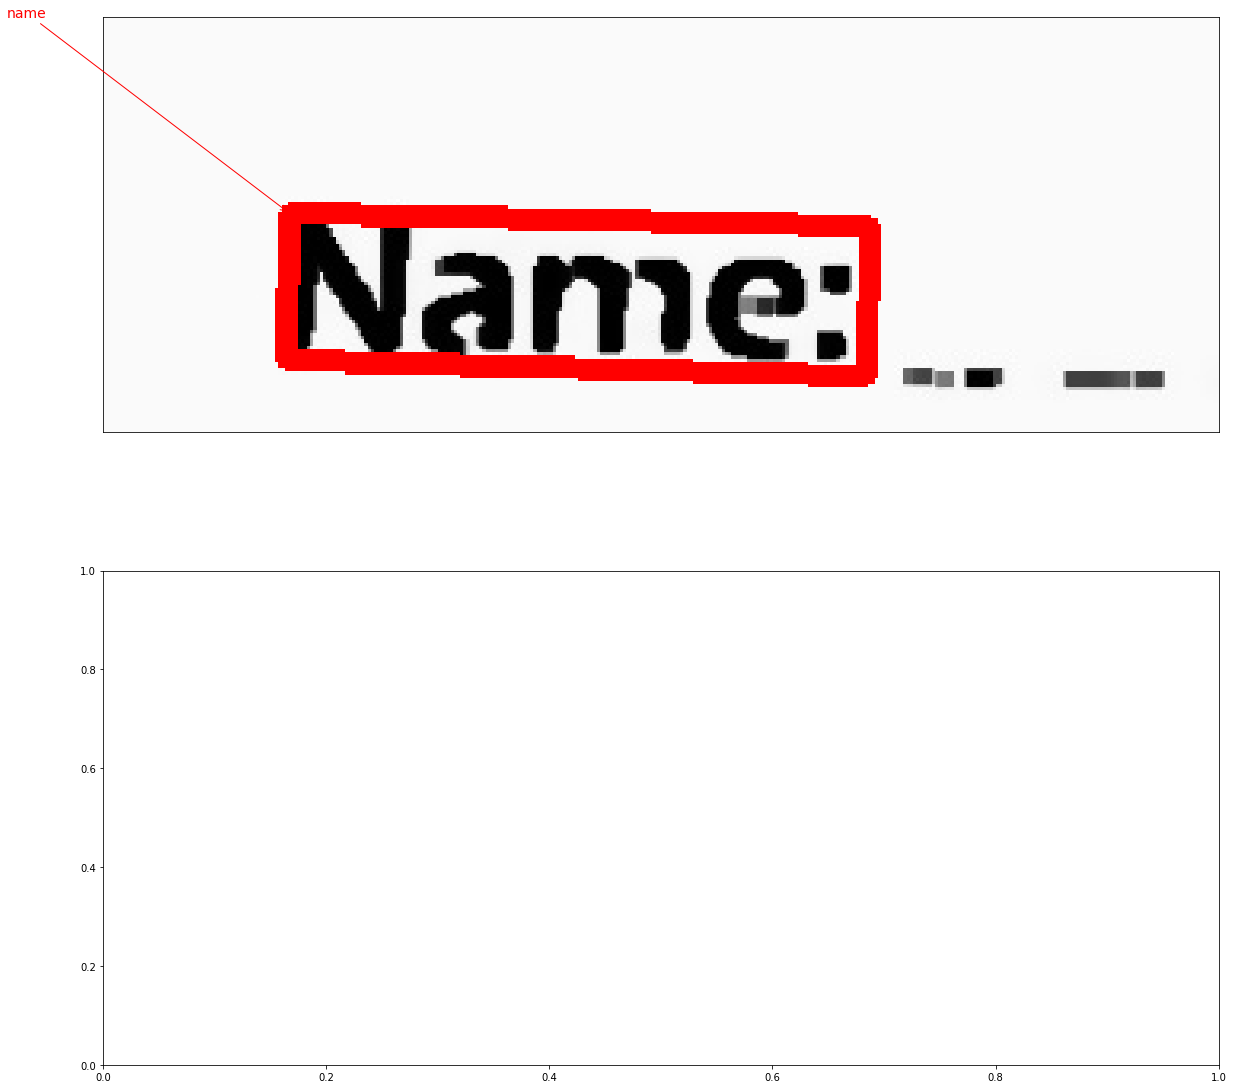

In [13]:

def run():
    rgb("pdf1.jpg")
    in_time = time.time()
    img_files = []
    for i in os.listdir():
        if i.startswith("i") or i.startswith("bl_"):
            img_files.append(i)
    for j in img_files:
        if j.startswith("ib"):
            color = "blue"
            text_init(j,"resize/er_bi_",color)
#         if j.startswith("ir"):
#             print("{} image is in process".format(j))
#             color = "red"
#             text_init(j,"resize/gauss_sh",color)
#         if j.startswith("ig"):
#             print("{} image is in process".format(j))
#             color = "green"
#             text_init(j,"resize/bid_sh",color)
#         if j.startswith("bl"):
#             color = "black"
#             text_init(j,"resize/gauss_sh",color)
        else:
            print("Sorry.. Invalid File")
    print(time.time() - in_time)
run()


In [23]:
img = cv2.imread("small.jpg",-1)
_, img = cv2.threshold(img,50,250,cv2.THRESH_BINARY)
plt.figure(figsize=(15,15))
# plt.imshow(img)

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

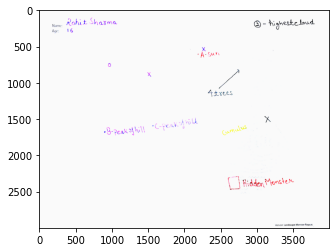

In [24]:
plt.imshow(img)

In [25]:
plt.imsave("newtry.jpg",img)